# IA307 - GPU Programming for Deep Learning

## Author: Gabriele LORENZO


# Installation


In [30]:
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


Download repository with helper_cuda.h:


In [31]:
!git clone https://github.com/NVIDIA/cuda-samples.git

fatal: destination path 'cuda-samples' already exists and is not an empty directory.


Based on the lecture at https://sites.google.com/site/frehseg/teaching/ia307


# Provided Code


## CUDA Utilities


In [32]:
%%writefile cuda_stuff.cuh
#include <stdio.h>
#include <stdlib.h>
#include <cuda.h>
#include <cuda_runtime.h>
#include <helper_cuda.h>

#ifndef cuda_stuff_H
#define cuda_stuff_H

/* transform matrix index to vector offset
   Since CUDA uses column major,
   nb_rows = number of rows */
#define IDX2C(i,j,nb_rows) (((j)*(nb_rows))+(i))

//MACRO TO DEBUGG CUDA FUNCTIONS
/** Error checking,
 *  taken from https://stackoverflow.com/questions/14038589/what-is-the-canonical-way-to-check-for-errors-using-the-cuda-runtime-api
 */
#define gpuErrchk(ans) { gpuAssert((ans), __FILE__, __LINE__); }
inline void gpuAssert(cudaError_t code, const char *file, int line, bool abort=true)
{
   if (code != cudaSuccess)
   {
      fprintf(stderr,"GPUassert: %s %s %d\n", cudaGetErrorString(code), file, line);
      if (abort) exit(code);
   }
}

/** Error checking for use with CUDA Dynamic Parallelism */
/*
#define cdpErrchk(ans) { cdpAssert((ans), __FILE__, __LINE__); }
__device__ void cdpAssert(cudaError_t code, const char *file, int line, bool abort=true)
{
   if (code != cudaSuccess)
   {
      printf("GPU kernel assert: %s %s %d\n", cudaGetErrorString(code), file, line);
      if (abort) assert(0);
   }
}
*/

void device_synchronize();

#endif

Overwriting cuda_stuff.cuh


In [33]:
%%writefile cuda_stuff.cu
#include <stdio.h>
#include <stdlib.h>
#include <cuda.h>
#include <cuda_runtime.h>
#include <helper_cuda.h>
#include "cuda_stuff.cuh"

void device_synchronize() {
    gpuErrchk(cudaDeviceSynchronize());
}

Overwriting cuda_stuff.cu


## fmatrix Matrix Tools


In [34]:
%%writefile fmatrix.cuh
#ifndef fmatrices_H
#define fmatrices_H
#include "cuda_stuff.cuh" // for IDX2C

////////////////////////////////////////
// basic data structure and access macro
////////////////////////////////////////
typedef struct {
    float* data;
    int cols;
    int rows;
} fmatrix;

/** Access element (i,j) of matrix M
 *
 *  Usage example:
 *  For computing A = B^T + C), loop over i and j with:
 *    getfm(A,i,j) = getfm(B,j,i) + getfm(C,i,j);
 **/
#define getfm(M,i,j) (M.data[IDX2C(i,j,M.rows)])

////////////////////////////////////////
// utility functions
////////////////////////////////////////
/** Returns the number of elements in the matrix.
 *
 *  Useful for computing, e.g., the size
 *  of a 1D-vector that contains the same numbers.
 */
 __host__
 __device__
int fmatrix_elements(fmatrix mat);

/** Returns the memory occupied by the matrix elements in bytes
 *  (not including the variables in the struct mat).
 *
 *  Useful for allocating memory for the data.
 */
 __host__
 __device__
int fmatrix_size(fmatrix mat);

/** Assert that the matrix is coherent: all fields nonzero. */
 __host__
 __device__
void fmatrix_assert(fmatrix mat);

////////////////////////////////////////
// Create, copy, destroy
////////////////////////////////////////
/** Allocate memory on host */
fmatrix fmatrix_create_on_host(int rows, int cols);

/** Allocate memory on device */
fmatrix fmatrix_create_on_device(int rows, int cols);

/** Create a matrix representing columns [a,b) of M.
 *  Note that the new matrix uses a pointer to the
 *  data of M. The data is not copied to a new location.
 *  If M is destroyed, this matrix is useless.
 */
fmatrix fmatrix_subcolumns(fmatrix M, int a, int b);

/** Copy data from matrix on device to host
 *  (no memory allocation). */
void fmatrix_data_to_host(fmatrix mat_host, fmatrix mat_device);

/** Copy data from matrix on host to device
 *  (no memory allocation). */
void fmatrix_data_to_device(fmatrix mat_host, fmatrix mat_device);

/** Copy matrix from device to host, allocating new memory. */
fmatrix fmatrix_copy_to_host(fmatrix mat_device);

/** Copy matrix from host to device, allocating new memory. */
fmatrix fmatrix_copy_to_device(fmatrix mat_host);

/** Free data memory on host.
 *  This zeros out the data pointer of the fmatrix struct,
 *  so a pointer is required. */
void fmatrix_free_on_host(fmatrix* mat);

/** Free data memory on device.
 *  This zeros out the data pointer of the fmatrix struct,
 *  so a pointer is required. */
void fmatrix_free_on_device(fmatrix* mat);

////////////////////////////////////////
// Input and Output
////////////////////////////////////////

/** Print the first nb rows of the matrix mat
 *  on the host.
 *  If nb<0, print all rows.
 */
 __host__
 __device__
void fmatrix_print(fmatrix mat, int nb=-1);

/** Print the first nb rows of the matrix mat
 *  on the device.
 *  If nb<0, print all rows.
 *
 *  This version copies the matrix to host first.
 */
void fmatrix_device_print(fmatrix mat, int nb=-1);

/** Print a matrix to a csv file.
 *
 *  This version copies the matrix to host first.
 */
void fmatrix_device_to_csv(const char* filename, fmatrix mat);

/** Read a matrix from a csv file.
 *
 *  This version creates the matrix on the host first.
 */
fmatrix fmatrix_device_from_csv(const char* filename);

////////////////////////////////////////
// Useful
////////////////////////////////////////

/** Create a matrix with random values between -1 and 1
 *  on the device */
fmatrix fmatrix_create_random_on_device(int rows, int cols);

#endif

Overwriting fmatrix.cuh


In [35]:
%%writefile fmatrix.cu
#include <assert.h>
#include <stdio.h>
#include <stdlib.h>
#include <cuda.h>
#include <cuda_runtime.h>
#include <helper_cuda.h>
#include <curand.h>
#include <curand_kernel.h>
#include "cuda_stuff.cuh"
#include "fmatrix.cuh"

// for reading CSV files, we use some C++
#include <iostream>
#include <iomanip>
#include <fstream>
#include <string>

int fmatrix_elements(fmatrix mat) {
    return mat.cols*mat.rows;
}

int fmatrix_size(fmatrix mat) {
    //fmatrix_assert(mat);
    return fmatrix_elements(mat) * sizeof(float);
}

void fmatrix_assert(fmatrix mat) {
    assert(mat.data);
    assert(mat.cols);
    assert(mat.rows);
}

fmatrix fmatrix_create_on_host(int rows, int cols) {
    assert(cols>0);
    assert(rows>0);
    fmatrix mat;
    mat.cols = cols;
    mat.rows = rows;
    mat.data = (float*)malloc(fmatrix_size(mat));
    assert(mat.data);
    return mat;
}

fmatrix fmatrix_create_on_device(int rows, int cols) {
    assert(cols>0);
    assert(rows>0);
    fmatrix mat;
    mat.cols = cols;
    mat.rows = rows;
    gpuErrchk(
        cudaMalloc((void **)&(mat.data), fmatrix_size(mat))
    );
    return mat;
}

void fmatrix_data_to_device(fmatrix mat_host, fmatrix mat_device) {
    fmatrix_assert(mat_host);
    fmatrix_assert(mat_device);
    assert(mat_host.cols==mat_device.cols);
    assert(mat_host.rows==mat_device.rows);
    gpuErrchk(
        cudaMemcpy( mat_device.data, mat_host.data,
                   fmatrix_size(mat_host),
                   cudaMemcpyHostToDevice
                   )
    );
}

void fmatrix_data_to_host(fmatrix mat_host, fmatrix mat_device) {
    fmatrix_assert(mat_host);
    fmatrix_assert(mat_device);
    assert(mat_host.cols==mat_device.cols);
    assert(mat_host.rows==mat_device.rows);
    gpuErrchk(
        cudaMemcpy( mat_host.data, mat_device.data,
                   fmatrix_size(mat_device),
                   cudaMemcpyDeviceToHost
                   )
    );
}

fmatrix fmatrix_copy_to_host(fmatrix mat_device) {
    fmatrix_assert(mat_device);
    fmatrix mat_host = fmatrix_create_on_host(mat_device.rows, mat_device.cols);
    fmatrix_data_to_host(mat_host,mat_device);
    return mat_host;
}

fmatrix fmatrix_copy_to_device(fmatrix mat_host) {
    fmatrix_assert(mat_host);
    fmatrix mat_device = fmatrix_create_on_device(mat_host.rows, mat_host.cols);
    fmatrix_data_to_device(mat_host,mat_device);
    return mat_device;
}

/** We could do it like this, but it would not set our pointer M.data to 0.
... fmatrix_free_on_host(M)
void fmatrix_free_on_host(fmatrix mat) {
    fmatrix_assert(mat);
  free(mat.data);
  mat.data = 0;
  mat.cols = 0;
  mat.rows = 0;
}
*/

void fmatrix_free_on_host(fmatrix* mat) {
    fmatrix_assert(*mat);
    free(mat->data);
    mat->data = 0;
    mat->cols = 0;
    mat->rows = 0;
}

void fmatrix_free_on_device(fmatrix* mat) {
    fmatrix_assert(*mat);
    gpuErrchk(cudaFree(mat->data));
    mat->data = 0;
    mat->cols = 0;
    mat->rows = 0;
}

fmatrix fmatrix_subcolumns(fmatrix M, int a, int b) {
    fmatrix_assert(M);
    fmatrix A = {
        .data = &getfm(M,0,a),
        .cols = b-a,
        .rows = M.rows
    };
    fmatrix_assert(A);
    return A;
}

__host__
__device__
void fmatrix_print(fmatrix mat, int nb){
    if (nb<0 || nb > mat.rows) {
        nb = mat.rows;
    }
    printf("[\n");
    for (int i = 0 ; i < nb; i++){
      for (int j = 0 ; j<mat.cols; j++){
        printf("%f", getfm(mat,i,j));
        if (j+1<mat.cols) {
          printf(",\t");
        }
      }
      if (i+1<nb) {
        printf(";\n");
      }
    }
    if (nb < mat.rows) {
      printf("\n...\n");
    }
  printf("\n]\n");
}

void fmatrix_device_print(fmatrix mat, int nb){
   // allocate copy
   fmatrix tmp = fmatrix_copy_to_host(mat);
   fmatrix_print(tmp,nb);
   fmatrix_free_on_host(&tmp);
}

void fmatrix_device_to_csv(const char* filename, fmatrix mat) {
  // Open file
  FILE* fp = fopen(filename, "w");
  // allocate copy
  fmatrix tmp = fmatrix_copy_to_host(mat);
  for (int i = 0 ; i < tmp.rows; i++){
    for (int j = 0 ; j<tmp.cols; j++){
      // Note: %.15g gives 15 significant digits (full double precision)
      fprintf(fp,"%.15g", getfm(tmp,i,j));
      if (j+1<tmp.cols) {
        fprintf(fp,",");
      }
    }
    fprintf(fp,"\n");
  }
  fmatrix_free_on_host(&tmp);
  // Close file
  fclose(fp);
}

__global__
void fmatrix_create_random_on_device_kernel(fmatrix M) {
    // choose a seed (here: the same each launch)
    unsigned long seed = 0;
    int sequence = 0;
    // first, initialize the random numbers
    curandState state;
    curand_init(seed, sequence, 0, &state);
    for (int i = 0; i < fmatrix_elements(M); ++i) {
        // curand_uniform creates numbers between 0 and 1
        M.data[i] = (curand_uniform(&state)-0.5)*2.0;
    }
}

fmatrix fmatrix_create_random_on_device(int rows, int cols) {
    // Create an uninitialized matrix on the device
    fmatrix M = fmatrix_create_on_device(rows,cols);
    // Call a kernel with a single thread to fill the values
    fmatrix_create_random_on_device_kernel<<<1,1>>>(M);

    return M;
}

/* Count the number of rows and columns in a csv files (without headers) */
void count_elements_in_csv(const char* filename, int* rows, int* cols) {
  // Note: for the sake of convenience, we use some C++ functions here
  using namespace std;

    *rows = 0;
    *cols = 0;
    string row_as_string;
    string value;
    ifstream infile;
    infile.open(filename, ifstream::in);
    if (infile.is_open()) {
        while (getline(infile, row_as_string, '\n')) {
            istringstream line_stream(row_as_string);
            int tempcols = 0;
            while (getline(line_stream, value, ',')) {
            ++tempcols;
            }
            if (tempcols > *cols) {
            *cols = tempcols;
            }
            ++(*rows);
        }
            infile.close();
    }
    else cout << "Cannot open file." << endl;
}

/** Read the data from a csv file into an fmatrix on the host.
 *  Careful: We assume that the matrix has the right dimensions!
 *  Use count_elements_in_csv(...) to get the dimensions if
 *  unknown.
 */
void fmatrix_fill_from_csv(fmatrix h_M,const char* filename) {
    // Note: for the sake of convenience, we use some C++ functions here
    using namespace std;
    string row_as_string;
    string value;
    ifstream infile;
    infile.open(filename, ifstream::in);
    int row = 0;
    if (infile.is_open()) {
        while (getline(infile, row_as_string, '\n')) {
                    istringstream line_stream(row_as_string);
            int col = 0;
            while (getline(line_stream, value, ',')) {
                        getfm(h_M,row,col) = strtod(value.c_str(), NULL);
            ++col;
                    }
            ++row;
                }
            infile.close();
    }
    else cout << "Cannot open file." << endl;
}

fmatrix fmatrix_device_from_csv(const char* filename) {
    // first read the file to count the number of elements
    int rows = 0;
    int cols = 0;
    count_elements_in_csv(filename,&rows,&cols);

    // allocate the matrix on the host
    fmatrix h_M = fmatrix_create_on_host(rows,cols);

    // read the data into the host matrix
    fmatrix_fill_from_csv(h_M,filename);

    // copy the matrix to the device
    fmatrix M = fmatrix_copy_to_device(h_M);

    // destroy the host matrix
    fmatrix_free_on_host(&h_M);

    return M;
}

Overwriting fmatrix.cu


## Data I/O


In [36]:
%%writefile read_csv.cuh
#include <cuda_runtime.h>
#ifndef read_csv_H
#define read_csv_H

void read_csv(const char* filename, float* data_array, int nbrow, int nbcol);

#endif

Overwriting read_csv.cuh


In [37]:
%%writefile read_csv.cu


#include <stdio.h>
#include <stdlib.h>
#include <string.h>

#include <iostream>
#include <iomanip>
#include <math.h>
#include <fstream>

#include "read_csv.cuh"
#include "cuda_stuff.cuh" // for matrix indexing

using namespace std;

/////////////////////////////////////////////////////////
// Functions for reading the dataset from a file
/////////////////////////////////////////////////////////

/* Read a csv file with a given number of rows and columns */
void read_csv(const char* filename, float* data_array, int nbrow, int nbcol) {
    string row_as_string;
    string value;
    double ioTemp;
    ifstream infile;
    infile.open(filename, ifstream::in);
    int row_count = 0;

	if (infile.is_open()) {
      // read the headers (and discard)
			getline(infile, row_as_string, '\n');
      // cout << "headers: " << row_as_string << "!" << std::endl;
      for(int i = 0; i < nbrow; i++){
  			getline(infile, row_as_string, '\n');
        // cout << "read line " << row_as_string << "!" << std::endl;
				istringstream line_stream(row_as_string);
			  for(int j = 0; j < nbcol; j++){
          getline(line_stream, value, ',');
					ioTemp = strtod(value.c_str(), NULL);
          // cout << "("<<i<<","<<j<<") = "<< ioTemp << std::endl;

					data_array[IDX2C(i,j,nbrow)] = ioTemp;
				}
        ++row_count;
			}
		infile.close();
    //cout << "Read " << row_count << " rows." << std::endl;
	}
	else cout << "Cannot open file." << endl;
}



Overwriting read_csv.cu


In [38]:
%%writefile preprocess_data.cuh

#include <cuda_runtime.h>
#ifndef preprocess_data_H
#define preprocess_data_H

void get_inputs_and_labels(float* data_array, float** input_array, float** label_array, int nbrows, int nbcols, int nb_inputs, int nb_labels );

#endif

Overwriting preprocess_data.cuh


In [39]:
%%writefile preprocess_data.cu
#include <stdio.h>
#include <stdlib.h>
#include <string.h>

#include <iostream>
#include <iomanip>
#include <math.h>
#include <fstream>

/*Matrix multiplication functions and other auxiliary functions*/
#include "preprocess_data.cuh"

using namespace std;

/* transform matrix index to vector offset
   Since CUDA uses column major,
   ld = number of rows
   Example of use: a[IDX2C(0, 1, 50)] */
#define IDX2C(i,j,ld) (((j)*(ld))+(i))

//Number of thread per block
#define THREADS_PER_BLOCK 1024
/* Constants for housing data set */
#define data_columns  (9)
#define above_threshold (265000.0)

/////////////////////////////////////////////////////////
// Number of rows in arrays to print for debugging
/////////////////////////////////////////////////////////
#define print_rows (10)
/////////////////////////////////////////////////////////
// Functions for preprocessing the data set
/////////////////////////////////////////////////////////

/* Split data into inputs and labels. Allocated memory for inputs and labels.
   Since cuBLAS is column major, each input is in a column.
   We also add 1.0 as first element to each input vector.
*/
void get_inputs_and_labels(float* data_array, float** input_array, float** label_array, int nbrows, int nbcols, int nb_inputs, int nb_labels ) {
    // The inputs are the first nbrows-1 columns.
    // The labels are the last column (index nbrows-1), booleanized
    // by the condition >= above_threshold
    *input_array = (float *)malloc(nbrows * nb_inputs * sizeof(float));
    *label_array = (float *)malloc(nbrows * nb_labels * sizeof(float));
    //cout << &input_array << " and "<< &label_array << " data " << data_array << std::endl;
    //cout << "Allocated memory for inputs: " << nbrows << " rows, "<< nb_inputs << " columns." << std::endl;
    //cout << "Allocated memory for labels: " << nbrows << " rows, "<< nb_labels << " columns." << std::endl;

    // Copy the data to X
    for(int i = 0; i < nbrows; i++){
        // Set the first element of each x to 1
        (*input_array)[IDX2C(0,i,nb_inputs)] = 1.0;
        // Copy the rest of x
			for(int j = 1; j < nb_inputs; j++){
				(*input_array)[IDX2C(j,i,nb_inputs)] = data_array[IDX2C(i,j-1,nbrows)];
			}
        float median_house_value = data_array[IDX2C(i,nbcols-1,nbrows)];
        (*label_array)[IDX2C(0,i,nb_labels)] = 0.0;
        (*label_array)[IDX2C(1,i,nb_labels)] = 0.0;
        if (median_house_value >= above_threshold) {
            (*label_array)[IDX2C(0,i,nb_labels)] = 1.0;
        } else {
            (*label_array)[IDX2C(1,i,nb_labels)] = 1.0;
        }
	}

    // Show some entries for double checking
    //cout << "Inputs (first "<<print_rows<<"):" << std::endl;
    for(int j = 0; j < nb_inputs; j++){
        for(int i = 0; i < nbrows && i < print_rows; i++){
                //cout << (*input_array)[IDX2C(j,i,nb_inputs)] << "\t";
            }
        //cout << "\n";
    }
    //cout << "Labels (first "<<print_rows<<"):" << std::endl;
    for(int j = 0; j < nb_labels; j++){
        for(int i = 0; i < nbrows && i < print_rows; i++){
				//cout << (*label_array)[IDX2C(j,i,nb_labels)] << "\t";
			}
        //cout << "\n";
	}
}

Overwriting preprocess_data.cu


# Code That You Write


## Classifier Math


In [40]:
%%writefile classifier_math.cuh
#ifndef classifier_math_H
#define classifier_math_H

#include "fmatrix.cuh"

/** Returns a random float between min and max (including). */
float float_rand(float min, float max);

/** Initialize W with Xavier's method,
 *  scaled by a. */
void xavier_weight_init(float a, fmatrix W);

/* Compute A = f*B*C */
void fmatrix_mult(fmatrix A, float f, fmatrix B, fmatrix C);

/* Compute A = f*B^T*C */
void fmatrix_tmult(fmatrix A, float f, fmatrix B, fmatrix C);

///////////////////////////////////
// TO BE COMPLETED
// ... add your matrix math here
///////////////////////////////////

/* Compute A = B-C */
void fmatrix_sub(fmatrix A, fmatrix B, fmatrix C);

/* Compute A = f*A */
void fmatrix_scalar_mult(fmatrix A, float f);

/* Compute A = f*B*C^T */
void fmatrix_mult_t(fmatrix A, float f, fmatrix B, fmatrix C);

/** Compute the softmax for each column of Z and store in P **/
void fmatrix_stable_softmax(fmatrix P,fmatrix Z);

void fmatrix_compute_mean_std(fmatrix X, float* mu, float* sigma);

void fmatrix_normalize_matrix(fmatrix X, float* mu, float* sigma);

#endif

Overwriting classifier_math.cuh


In [41]:
%%writefile classifier_math.cu
#include "classifier_math.cuh"
#include "cuda_stuff.cuh"
#include <cuda.h>
#include <cuda_runtime.h>
#include <helper_cuda.h>
#include <math.h>
#include <assert.h>
#define THREADS_PER_BLOCK 1024

/////////////////////////////////////////////////////////
// Auxiliary function
/////////////////////////////////////////////////////////
// generate random numbers in interval [min,max]
float float_rand(float min, float max){
    float scale = rand() / (float) RAND_MAX; /* [0, 1.0] */
    return min + scale * ( max - min );      /* [min, max] */
}

void xavier_weight_init(float a, fmatrix W){
    for (int j = 0; j < W.rows  ; ++j) {
      for (int i = 0; i < W.cols  ; ++i) {
          getfm(W,j,i) = a * (1.0/sqrt(W.cols+W.rows)) * float_rand(-1.0,1.0);
      }
    }
}

__global__
void fmatrix_stable_softmax_kernel(fmatrix P,fmatrix Z) {
    // Each thread processes one column of Z
    int col = blockIdx.x * blockDim.x + threadIdx.x;

    if (col < Z.cols) {
        float max_val = getfm(Z, 0, col);
        for (int row = 1; row < Z.rows; row++) {
            float val = getfm(Z, row, col);
            if (val > max_val) {
                max_val = val;
            }
        }

        float sum = 0.0f;
        for (int row = 0; row < Z.rows; row++) {
            float exp_val = expf(getfm(Z, row, col) - max_val);
            getfm(P, row, col) = exp_val;
            sum += exp_val;
        }

        for (int row = 0; row < Z.rows; row++) {
            getfm(P, row, col) /= sum;
        }
    }
}

void fmatrix_stable_softmax(fmatrix P,fmatrix Z) {
    fmatrix_assert(P);
    fmatrix_assert(Z);
    assert(P.cols==Z.cols);
    assert(P.rows==Z.rows);

    int threadsPerBlock = Z.cols;
    int blocksPerGrid = 1;
    if (threadsPerBlock > THREADS_PER_BLOCK){
        blocksPerGrid = (threadsPerBlock-1)/THREADS_PER_BLOCK+1;
        threadsPerBlock = THREADS_PER_BLOCK;
    }
    fmatrix_stable_softmax_kernel<<< blocksPerGrid, threadsPerBlock >>>(P, Z);
    gpuErrchk(cudaPeekAtLastError());
    device_synchronize();
}

__global__
void fmatrix_sub_kernel(fmatrix A, fmatrix B, fmatrix C) {
    int row = blockIdx.x * blockDim.x + threadIdx.x;
    int col = blockIdx.y * blockDim.y + threadIdx.y;

    if (row < A.rows && col < A.cols) {
        getfm(A, row, col) = getfm(B, row, col) - getfm(C, row, col);
    }
}

void fmatrix_sub(fmatrix A, fmatrix B, fmatrix C) {
    fmatrix_assert(A);
    fmatrix_assert(B);
    fmatrix_assert(C);

    assert(A.rows == B.rows && A.cols == B.cols);
    assert(A.rows == C.rows && A.cols == C.cols);

    dim3 threadsPerBlock(16, 16);
    dim3 blocksPerGrid((A.rows + threadsPerBlock.x - 1) / threadsPerBlock.x,
                       (A.cols + threadsPerBlock.y - 1) / threadsPerBlock.y);

    fmatrix_sub_kernel<<<blocksPerGrid, threadsPerBlock>>>(A, B, C);
    gpuErrchk(cudaPeekAtLastError());
    device_synchronize();
}

__global__
void fmatrix_scalar_mult_kernel(fmatrix A, float f) {
    int row = blockIdx.x * blockDim.x + threadIdx.x;
    int col = blockIdx.y * blockDim.y + threadIdx.y;

    if (row < A.rows && col < A.cols) {
        getfm(A, row, col) *= f;
    }
}

void fmatrix_scalar_mult(fmatrix A, float f) {
    fmatrix_assert(A);

    dim3 threadsPerBlock(16, 16);
    dim3 blocksPerGrid((A.rows + threadsPerBlock.x - 1) / threadsPerBlock.x,
                       (A.cols + threadsPerBlock.y - 1) / threadsPerBlock.y);

    fmatrix_scalar_mult_kernel<<<blocksPerGrid, threadsPerBlock>>>(A, f);
    gpuErrchk(cudaPeekAtLastError());
    device_synchronize();
}

__global__
void fmatrix_multiplication_kernel(fmatrix A, float f, fmatrix B, fmatrix C) {
    // Each thread multiplies one row of B with one column of C
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    int j = blockIdx.y * blockDim.y + threadIdx.y;
    if (i < A.rows && j < A.cols ){
        getfm(A,i,j) = 0.0;
        for (int k = 0; k < B.cols; ++k) {
          getfm(A,i,j) += f*getfm(B,i,k)*getfm(C,k,j);
        }
    }
}

/* Compute A = f*B*C */
void fmatrix_mult(fmatrix A, float f, fmatrix B, fmatrix C) {
    // First let's check for errors in the argument M.
    // This can help a LOT when debugging.
    // A,B,C need to have nonzero pointers etc.
    // fmatrix_assert(A);
    // fmatrix_assert(B);
    // fmatrix_assert(C);
    assert(A.rows == B.rows);
    assert(A.cols == C.cols);
    assert(B.cols == C.rows);

    // take one thread per element, and distribute
    // over as many blocks as necessary given
    // the hardware limit on the number of threads per block
    int threadsPerBlock = fmatrix_elements(A);
    int blocksPerGrid = 1;
    if (threadsPerBlock > THREADS_PER_BLOCK){
        blocksPerGrid = (threadsPerBlock-1)/THREADS_PER_BLOCK+1;
        threadsPerBlock = THREADS_PER_BLOCK;
    }
    fmatrix_multiplication_kernel<<< blocksPerGrid, threadsPerBlock >>>(A,f,B,C);
    // check for errors
    gpuErrchk( cudaPeekAtLastError() );
    // wait for the kernel to finish
    device_synchronize();
}

//// Multiplication de matrice avec transposé
__global__
void fmatrix_tmultiplication_kernel(fmatrix A, float f, fmatrix B, fmatrix C) {
    // Each thread multiplies one row of B with one column of C
    int idx = blockIdx.x*blockDim.x+threadIdx.x;
    int j = idx / A.rows;
    int i = idx % A.rows;
    if (i < A.rows && j < A.cols ){
        getfm(A,i,j) = 0.0;
        for (int k = 0; k < B.rows; ++k) {
          getfm(A,i,j) += f*getfm(B,k,i)*getfm(C,k,j);
        }
    }
}

/* Compute A = f*B^T*C */
void fmatrix_tmult(fmatrix A, float f, fmatrix B, fmatrix C) {
    // First let's check for errors in the argument M.
    // This can help a LOT when debugging.
    // A,B,C need to have nonzero pointers etc.
    // fmatrix_assert(A);
    // fmatrix_assert(B);
    // fmatrix_assert(C);
    assert(A.rows == B.cols);
    assert(A.cols == C.cols);
    assert(B.rows == C.rows);

    // take one thread per element, and distribute
    // over as many blocks as necessary given
    // the hardware limit on the number of threads per block
    int threadsPerBlock = fmatrix_elements(A);
    int blocksPerGrid = 1;
    if (threadsPerBlock > THREADS_PER_BLOCK){
        blocksPerGrid = (threadsPerBlock-1)/THREADS_PER_BLOCK+1;
        threadsPerBlock = THREADS_PER_BLOCK;
    }
    fmatrix_tmultiplication_kernel<<< blocksPerGrid, threadsPerBlock >>>(A,f,B,C);
    // check for errors
    gpuErrchk(cudaPeekAtLastError());
    // wait for the kernel to finish
    device_synchronize();
}

/* Compute A = f*B*C^T */
__global__
void fmatrix_multiplication_t_kernel(fmatrix A, float f, fmatrix B, fmatrix C) {
    int row = blockIdx.x * blockDim.x + threadIdx.x;
    int col = blockIdx.y * blockDim.y + threadIdx.y;

    if (row < A.rows && col < A.cols) {
        float sum = 0.0;
        for (int k = 0; k < B.cols; ++k) {
            sum += f * getfm(B, row, k) * getfm(C, col, k);
        }
        getfm(A, row, col) = sum;
    }
}

/* Compute A = f*B*C^T */
void fmatrix_mult_t(fmatrix A, float f, fmatrix B, fmatrix C) {
    // Argument checks
    assert(A.rows == B.rows);
    assert(A.cols == C.rows);
    assert(B.cols == C.cols);

    // Distribute threads
    int threadsPerBlock = fmatrix_elements(A);
    int blocksPerGrid = 1;
    if (threadsPerBlock > THREADS_PER_BLOCK) {
        blocksPerGrid = (threadsPerBlock - 1) / THREADS_PER_BLOCK + 1;
        threadsPerBlock = THREADS_PER_BLOCK;
    }

    fmatrix_multiplication_t_kernel<<<blocksPerGrid, threadsPerBlock>>>(A, f, B, C);

    // Check for errors and synchronize
    gpuErrchk(cudaPeekAtLastError());
    device_synchronize();
}

__global__
void compute_mean_std_kernel(fmatrix X, float* mu, float* sigma) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;

    if (idx < X.rows) {
        float sum = 0.0, sum_sq = 0.0;

        for (int j = 0; j < X.cols; j++) {
            float val = getfm(X, idx, j);
            sum += val;
            sum_sq += val * val;
        }

        mu[idx] = sum / X.cols;
        float variance = (sum_sq / X.cols) - (mu[idx] * mu[idx]);
        sigma[idx] = sqrtf(variance + 1e-6); // Avoid division by zero
    }
}

void fmatrix_compute_mean_std(fmatrix X, float* mu, float* sigma) {
    fmatrix_assert(X);

    // Allocate device memory
    float* d_mu, *d_sigma;
    gpuErrchk(cudaMalloc((void**)&d_mu, X.rows * sizeof(float)));
    gpuErrchk(cudaMalloc((void**)&d_sigma, X.rows * sizeof(float)));

    // Allocate matrix on device
    fmatrix d_X = fmatrix_create_on_device(X.rows, X.cols);
    fmatrix_data_to_device(X, d_X);

    // Launch kernel
    int blocks = (X.rows + THREADS_PER_BLOCK - 1) / THREADS_PER_BLOCK;
    compute_mean_std_kernel<<<blocks, THREADS_PER_BLOCK>>>(d_X, d_mu, d_sigma);
    gpuErrchk(cudaPeekAtLastError());
    gpuErrchk(cudaDeviceSynchronize());

    // Copy results back to host
    gpuErrchk(cudaMemcpy(mu, d_mu, X.rows * sizeof(float), cudaMemcpyDeviceToHost));
    gpuErrchk(cudaMemcpy(sigma, d_sigma, X.rows * sizeof(float), cudaMemcpyDeviceToHost));

    // Free device memory
    cudaFree(d_mu);
    cudaFree(d_sigma);
    fmatrix_free_on_device(&d_X);
}

__global__
void normalize_matrix_kernel(fmatrix X, float* mu, float* sigma) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;

    if (idx < X.rows) {
        for (int j = 0; j < X.cols; j++) {
            getfm(X, idx, j) = (getfm(X, idx, j) - mu[idx]) / sigma[idx];
        }
    }
}

void fmatrix_normalize_matrix(fmatrix X, float* mu, float* sigma) {
    fmatrix_assert(X);

    // Allocate GPU memory
    fmatrix d_X = fmatrix_create_on_device(X.rows, X.cols);
    fmatrix_data_to_device(X, d_X);

    // Copy mu and sigma to device
    float* d_mu, *d_sigma;
    gpuErrchk(cudaMalloc((void**)&d_mu, X.rows * sizeof(float)));
    gpuErrchk(cudaMalloc((void**)&d_sigma, X.rows * sizeof(float)));

    gpuErrchk(cudaMemcpy(d_mu, mu, X.rows * sizeof(float), cudaMemcpyHostToDevice));
    gpuErrchk(cudaMemcpy(d_sigma, sigma, X.rows * sizeof(float), cudaMemcpyHostToDevice));

    // Launch kernel
    int blocks = (X.rows + THREADS_PER_BLOCK - 1) / THREADS_PER_BLOCK;
    normalize_matrix_kernel<<<blocks, THREADS_PER_BLOCK>>>(d_X, d_mu, d_sigma);

    // Check for kernel errors
    gpuErrchk(cudaPeekAtLastError());
    gpuErrchk(cudaDeviceSynchronize());

    // Copy results back to host
    fmatrix_data_to_host(X, d_X);

    // Free GPU memory
    cudaFree(d_mu);
    cudaFree(d_sigma);
    fmatrix_free_on_device(&d_X);
}

Overwriting classifier_math.cu


## Evaluating Accuracy


In [42]:
%%writefile evaluate_accuracy.cuh

/** Evaluate the accuracy of a linear classifier with D x M weight
 *  matrix W, using D x N input data X and M x N output labels Y.
 *  Z is a temporary matrix with dimensions M x N,
 *  which must be previously allocated.
 */
float evaluate_accuracy(fmatrix d_W, fmatrix d_X, fmatrix d_Y, fmatrix d_Z);

/** Compute the logloss given M x N matrices of
 *  probabilities P and output labels Y
 *  and stores it in J.
 *  J is a matrix with dimensions 1 x 1,
 *  which must be previously allocated.
 *  logloss = sum_j -Y(j,k)*log(P(j,k))
 */
float evaluate_logloss(fmatrix d_P, fmatrix d_Y);

Overwriting evaluate_accuracy.cuh


In [43]:
%%writefile evaluate_accuracy.cu
#include "fmatrix.cuh"
#include "classifier_math.cuh"
#include <assert.h>

#define THREADS_PER_BLOCK 1024

__global__
void evaluate_accuracy_kernel(fmatrix d_Y, fmatrix d_Z, int* count) {
    int idx = blockIdx.x*blockDim.x+threadIdx.x;
    if (idx < d_Z.cols){
        float z_max = getfm(d_Z,0,idx);
        int i_max = 0;
        for (int i = 1; i < d_Z.rows; ++i) {
          if (getfm(d_Z,i,idx)>z_max) {
                z_max = getfm(d_Z,i,idx);
                i_max = i;
          }
        }
      if (getfm(d_Y,i_max,idx)>=0.5f) {
          atomicAdd(count,1);
      }
    }
}

float evaluate_accuracy(fmatrix d_W, fmatrix d_X, fmatrix d_Y, fmatrix d_Z) {
    assert(d_Y.cols == d_Z.cols);
    assert(d_Y.rows == d_Z.rows);

    //////////////////////////////////////////
    // 1. compute Z = W^T X
    // --> each column of Z corresponds to one input
    //////////////////////////////////////////
    /*********************************
    / TO BE COMPLETED
    / ... compute Z = W^T X here ...
    **********************************/
    fmatrix_tmult(d_Z, 1.0, d_W, d_X);

    //////////////////////////////////////////
    // 2. For each column z of Z,
    // find argmax_k z_k
    //////////////////////////////////////////
    fmatrix d_P = fmatrix_create_on_device(d_Z.rows, d_Z.cols);
    fmatrix_stable_softmax(d_P, d_Z);

    int true_class = 0;

    int* d_count = 0;
    gpuErrchk(cudaMalloc((void **)&d_count, sizeof(int)));
    gpuErrchk(
          cudaMemcpy( d_count, &true_class, sizeof(int), cudaMemcpyHostToDevice )
    );

    int threadsPerBlock = d_Z.cols;
    int blocksPerGrid = 1;
    if (threadsPerBlock > THREADS_PER_BLOCK){
        blocksPerGrid = (threadsPerBlock-1)/THREADS_PER_BLOCK+1;
        threadsPerBlock = THREADS_PER_BLOCK;
    }
    evaluate_accuracy_kernel<<< blocksPerGrid, threadsPerBlock >>>(d_Y, d_P, d_count);
    device_synchronize();
    gpuErrchk( cudaPeekAtLastError() );

    gpuErrchk(
            cudaMemcpy(&true_class, d_count, sizeof(int), cudaMemcpyDeviceToHost )
    );

    //int nb_tested = d_Z.cols;
    //printf("Correct results: %d out of %d\n",true_class,nb_tested);
    //printf("Accuracy: %f\n",(float)true_class/(float)nb_tested);
    return (float)true_class/(float)d_Z.cols;
}

__global__
void evaluate_logloss_kernel(fmatrix d_P, fmatrix d_Y, float* loss_sum) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx < d_P.cols) {
        float loss = 0.0f;
        for (int i = 0; i < d_P.rows; i++) {
            float p = getfm(d_P, i, idx);
            float y = getfm(d_Y, i, idx);
            if (y > 0.0f) {  // Only compute log for true class entries
                loss += y * logf(fmaxf(p, 1e-8f));  // Prevent log(0) by using fmaxf
            }
        }
        atomicAdd(loss_sum, -loss);
    }
}

float evaluate_logloss(fmatrix d_P, fmatrix d_Y) {
    assert(d_Y.cols == d_P.cols);
    assert(d_Y.rows == d_P.rows);

    ///////////////////////////////////
    // TO BE COMPLETED
    // ... compute the logloss here ...
    ///////////////////////////////////

    float J = 0.0f;
    float* d_loss_sum;
    gpuErrchk(cudaMalloc((void**)&d_loss_sum, sizeof(float)));
    gpuErrchk(cudaMemcpy(d_loss_sum, &J, sizeof(float), cudaMemcpyHostToDevice));

    int threadsPerBlock = d_P.cols;
    int blocksPerGrid = (threadsPerBlock > THREADS_PER_BLOCK) ?
                        (threadsPerBlock - 1) / THREADS_PER_BLOCK + 1 : 1;
    threadsPerBlock = min(threadsPerBlock, THREADS_PER_BLOCK);

    evaluate_logloss_kernel<<<blocksPerGrid, threadsPerBlock>>>(d_P, d_Y, d_loss_sum);

    device_synchronize();
    gpuErrchk(cudaPeekAtLastError());
    gpuErrchk(cudaMemcpy(&J, d_loss_sum, sizeof(float), cudaMemcpyDeviceToHost));

    cudaFree(d_loss_sum);

    return J / d_P.cols;  // Normalize by number of samples
}

Overwriting evaluate_accuracy.cu


In [44]:
!shuf sample_data/california_housing_train.csv > california_housing_train_shuf.csv

## Linear Classifier


In [45]:
%%writefile linear_classification.cu

#include <stdio.h>
#include <stdlib.h>
#include <string.h>

#include <iostream>
#include <iomanip>
#include <math.h>
#include <time.h>
#include <fstream>

/*Matrix multiplication functions and other auxiliary functions*/
#include "fmatrix.cuh"
#include "read_csv.cuh"
#include "preprocess_data.cuh"
#include "classifier_math.cuh"
#include "evaluate_accuracy.cuh"
/* Includes, cuda */
#include <cuda_runtime.h>
#include <helper_cuda.h>

using namespace std;

//Number of thread per block
#define THREADS_PER_BLOCK 1024
/* Constants for housing data set */
#define data_columns  (9)
#define above_threshold (265000.0)

/////////////////////////////////////////////////////////
// Number of rows in arrays to print for debugging
/////////////////////////////////////////////////////////
#define print_rows (10)

/////////////////////////////////////////////////////////
// Main program
/////////////////////////////////////////////////////////
int main(int argc, char **argv) {
    /////////////////////////////////////////////////////////
    // Parameters for the data set
    /////////////////////////////////////////////////////////
    size_t N_train = 12000; // points for training (Google: 12000)
    size_t N_test = 5000; // points for validation (Google: 5000)
    size_t N = N_train;
    size_t Nall = N_train + N_test;

    /////////////////////////////////////////////////////////
    // Reading the data set
    /////////////////////////////////////////////////////////
    fmatrix alldata = fmatrix_create_on_host(Nall, data_columns);
    read_csv("california_housing_train_shuf.csv", alldata.data, Nall,data_columns);
    //fmatrix_print(alldata);

    size_t D = data_columns - 1 + 1; // remove output column, add column with const. 1.0
    size_t M = 2; // number of labels (one-hot encoding)
    fmatrix Xall = fmatrix_create_on_host(D, Nall);
    fmatrix Yall = fmatrix_create_on_host(M, Nall);
    get_inputs_and_labels(alldata.data, &Xall.data, &Yall.data, Nall, data_columns, D, M);
    /////////////////////////////////////////////////////////
    // Inputs and labels are now available in X and Y.
    // Each input is a column in X; X is of dimension D x N
    // each label is a column in Y; Y is of dimension M x N
    /////////////////////////////////////////////////////////

    // Logfile
    FILE* fp = fopen("log.txt", "w");

    /////////////////////////////////////////////////////////
    // Parameters for Stochastic Gradient Descent
    /////////////////////////////////////////////////////////
    int nb_iter = 20;           // defeault: 10;
    int periods = nb_iter;      // reporting period
    int batch_size = N;         // defeault: N;
    float learning_rate = 1e-4; // default: 1e-7

    /////////////////////////////////////////////////////////
    // Memory Allocation and Initialization
    /////////////////////////////////////////////////////////
    // take X,Y to be the first N columns of all data
    fmatrix h_X = fmatrix_subcolumns(Xall, 0, N);
    fmatrix h_Y = fmatrix_subcolumns(Yall, 0, N);
    fmatrix h_Xtest = fmatrix_subcolumns(Xall, N, Nall);
    fmatrix h_Ytest = fmatrix_subcolumns(Yall, N, Nall);
    fmatrix h_W = fmatrix_create_on_host(D, M);
    fmatrix h_J = fmatrix_create_on_host(1, 1);

    /////////////////////////////////////////////////////////
    // Initializing Weight Matrix
    // its dimension is D x M
    /////////////////////////////////////////////////////////
    xavier_weight_init(1.0, h_W);

    /////////////////////////////////////////////////////////
    // Normalize d_X
    /////////////////////////////////////////////////////////
    float* mu = (float*)malloc(h_X.rows * sizeof(float));
    float* sigma = (float*)malloc(h_X.rows * sizeof(float));
    fmatrix_compute_mean_std(h_X, mu, sigma);

    fmatrix_normalize_matrix(h_X, mu, sigma);
    fmatrix_normalize_matrix(h_Xtest, mu, sigma);

    //////////////////////////////
    // Copy data to device
    //////////////////////////////
    fmatrix d_X = fmatrix_copy_to_device(h_X);
    fmatrix d_Y = fmatrix_copy_to_device(h_Y);
    fmatrix d_Xtest = fmatrix_copy_to_device(h_Xtest);
    fmatrix d_Ytest = fmatrix_copy_to_device(h_Ytest);
    fmatrix d_W = fmatrix_copy_to_device(h_W);
    fmatrix d_J = fmatrix_copy_to_device(h_J);

    /////////////////////////////////////////
    // Create auxiliary matrices on device
    /////////////////////////////////////////
    fmatrix d_Z = fmatrix_create_on_device(M, batch_size);
    fmatrix d_P = fmatrix_create_on_device(M, batch_size);
    fmatrix d_Q = fmatrix_create_on_device(M, batch_size);
    fmatrix d_G = fmatrix_create_on_device(D, M);
    // auxiliary matrix for computing Z=W^T X on test data
    fmatrix d_Ztest = fmatrix_create_on_device(M, d_Xtest.cols);

    /////////////////////////////////////////////////////////
    // Batch Gradient Descent
    /////////////////////////////////////////////////////////
    //fmatrix_device_print(d_X);
    //fmatrix_device_print(d_W);

    /* Evaluate the accuracy */
    float accuracy = 0;
    accuracy = evaluate_accuracy(d_W, d_Xtest, d_Ytest, d_Ztest);
    printf("initial accuracy: %f\n",accuracy);

    float J = 0;

    clock_t tstart_total, tend;
    tstart_total = clock();

    for (int i = 0; i < nb_iter; ++i) {
      ////////////////////////////////
      // compute Z = W^T X
      // --> each column z of Z corresponds to one column x of X
      ////////////////////////////////
      fmatrix_tmult(d_Z, 1.0, d_W, d_X);

      ////////////////////////////////
      // For each column z of Z, compute activation p(z);
      // then update W
      ////////////////////////////////
      // compute softmax per column of Z and store in Z
      fmatrix_stable_softmax(d_P, d_Z);

      // evaluate logloss (for reporting only)
      J = evaluate_logloss(d_P, d_Y);

      // Q:=P-Y
      fmatrix_sub(d_Q, d_P, d_Y);

      // compute gradient G = XQ^T
      fmatrix_mult_t(d_G, 1.0, d_X, d_Q);

      // update weights W = W - learning_rate*G
      fmatrix_scalar_mult(d_G, learning_rate);
      fmatrix_sub(d_W, d_W, d_G);

      device_synchronize();

      ////////////////////////////////
      // Compute logloss and accuracy
      ////////////////////////////////
      if (i % (nb_iter / periods) == 0) {
        float accuracy = evaluate_accuracy(d_W, d_Xtest, d_Ytest, d_Ztest);
        printf("Iter: %d, LogLoss: %f, Accuracy:  %f\n", i, J, accuracy);
        fprintf(fp, "%f,%f\n", J, accuracy);
      }
    }

    tend = clock();
    float duration = ((float)(tend-tstart_total))/CLOCKS_PER_SEC;
    printf("Duration (s): %f\n",duration);
    /* Evaluate the accuracy */
    accuracy = evaluate_accuracy(d_W, d_Xtest, d_Ytest, d_Ztest);
    printf("final accuracy: %f\n",accuracy);

    printf("final weights: \n");
    fmatrix_device_print(d_W);

    /* Memory clean up */
    /** No need to free h_X, h_Y, h_Xtest, h_Ytest since
     *  they all point to Xall
     */
    fmatrix_free_on_host(&h_W);
    fmatrix_free_on_host(&Xall);
    fmatrix_free_on_host(&Yall);

    fmatrix_free_on_device(&d_X);
    fmatrix_free_on_device(&d_Y);
    fmatrix_free_on_device(&d_Xtest);
    fmatrix_free_on_device(&d_Ytest);
    fmatrix_free_on_device(&d_W);
    fmatrix_free_on_device(&d_Z);
    fmatrix_free_on_device(&d_J);

    // Close log file
    fclose(fp);
}

Overwriting linear_classification.cu


## Linear Classifier with batches


In [46]:
%%writefile linear_classification_batches.cu

#include <stdio.h>
#include <stdlib.h>
#include <string.h>

#include <iostream>
#include <iomanip>
#include <math.h>
#include <time.h>
#include <fstream>

/*Matrix multiplication functions and other auxiliary functions*/
#include "fmatrix.cuh"
#include "read_csv.cuh"
#include "preprocess_data.cuh"
#include "classifier_math.cuh"
#include "evaluate_accuracy.cuh"
/* Includes, cuda */
#include <cuda_runtime.h>
#include <helper_cuda.h>

using namespace std;

//Number of thread per block
#define THREADS_PER_BLOCK 1024
/* Constants for housing data set */
#define data_columns  (9)
#define above_threshold (265000.0)

// SGD Mini Batch Parameters
#define BATCH_SIZE 128

/////////////////////////////////////////////////////////
// Number of rows in arrays to print for debugging
/////////////////////////////////////////////////////////
#define print_rows (10)

/////////////////////////////////////////////////////////
// Main program
/////////////////////////////////////////////////////////
int main(int argc, char **argv) {
    /////////////////////////////////////////////////////////
    // Parameters for the data set
    /////////////////////////////////////////////////////////
    size_t N_train = 12000; //12000; // points for training (Google: 12000)
    size_t N_test = 5000; // 5000; // points for validation (Google: 5000)
    size_t N = N_train;
    size_t Nall = N_train + N_test;

    /////////////////////////////////////////////////////////
    // Reading the data set
    /////////////////////////////////////////////////////////
    fmatrix alldata = fmatrix_create_on_host(Nall, data_columns);
    read_csv("california_housing_train_shuf.csv", alldata.data, Nall, data_columns);
    //fmatrix_print(alldata);

    size_t D = data_columns - 1 + 1; // remove output column, add column with const. 1.0
    size_t M = 2; // number of labels (one-hot encoding)
    fmatrix Xall = fmatrix_create_on_host(D, Nall);
    fmatrix Yall = fmatrix_create_on_host(M, Nall);
    get_inputs_and_labels(alldata.data, &Xall.data, &Yall.data, Nall, data_columns, D, M);

    /////////////////////////////////////////////////////////
    // Inputs and labels are now available in X and Y.
    // Each input is a column in X; X is of dimension D x N
    // each label is a column in Y; Y is of dimension M x N
    /////////////////////////////////////////////////////////

    // Logfile
    FILE* fp = fopen("log_batches.txt", "w");

    /////////////////////////////////////////////////////////
    // Parameters for Stochastic Gradient Descent
    /////////////////////////////////////////////////////////
    int nb_epochs = 20;                 // defeault: 10;
    float learning_rate = 1e-4;         // default: 1e-7

    /////////////////////////////////////////////////////////
    // Memory Allocation and Initialization
    /////////////////////////////////////////////////////////
    // take X,Y to be the first N columns of all data
    fmatrix h_X = fmatrix_subcolumns(Xall, 0, N);
    fmatrix h_Y = fmatrix_subcolumns(Yall, 0, N);
    fmatrix h_Xtest = fmatrix_subcolumns(Xall, N, Nall);
    fmatrix h_Ytest = fmatrix_subcolumns(Yall, N, Nall);
    fmatrix h_W = fmatrix_create_on_host(D, M);
    fmatrix h_J = fmatrix_create_on_host(1, 1);

    /////////////////////////////////////////////////////////
    // Initializing Weight Matrix
    // its dimension is D x M
    /////////////////////////////////////////////////////////
    xavier_weight_init(1.0, h_W);

    /////////////////////////////////////////////////////////
    // Normalize d_X
    /////////////////////////////////////////////////////////
    float* mu = (float*)malloc(h_X.rows * sizeof(float));
    float* sigma = (float*)malloc(h_X.rows * sizeof(float));
    fmatrix_compute_mean_std(h_X, mu, sigma);

    fmatrix_normalize_matrix(h_X, mu, sigma);
    fmatrix_normalize_matrix(h_Xtest, mu, sigma);

    //////////////////////////////
    // Copy data to device      //
    //////////////////////////////
    fmatrix d_X = fmatrix_copy_to_device(h_X);
    fmatrix d_Y = fmatrix_copy_to_device(h_Y);
    fmatrix d_Xtest = fmatrix_copy_to_device(h_Xtest);
    fmatrix d_Ytest = fmatrix_copy_to_device(h_Ytest);
    fmatrix d_W = fmatrix_copy_to_device(h_W);
    fmatrix d_J = fmatrix_copy_to_device(h_J);

    /////////////////////////////////////////
    // Create auxiliary matrices on device //
    /////////////////////////////////////////
    fmatrix d_Z = fmatrix_create_on_device(M, BATCH_SIZE);
    fmatrix d_P = fmatrix_create_on_device(M, BATCH_SIZE);
    fmatrix d_Q = fmatrix_create_on_device(M, BATCH_SIZE);
    fmatrix d_G = fmatrix_create_on_device(D, M);
    // auxiliary matrix for computing Z=W^T X on test data
    fmatrix d_Ztest = fmatrix_create_on_device(M, d_Xtest.cols);

    /////////////////////////////////////////////////////////
    // Batch Gradient Descent
    /////////////////////////////////////////////////////////

    /* Evaluate the accuracy */
    float accuracy = 0;
    accuracy = evaluate_accuracy(d_W, d_Xtest, d_Ytest, d_Ztest);
    printf("initial accuracy: %f\n",accuracy);

    float J = 0;

    clock_t tstart_total, tend;
    tstart_total = clock();

    for (int epoch = 0; epoch < nb_epochs; epoch++) {
      int batch_pointer = 0;
      J = 0;

      for (int batch = 0; batch < (N + BATCH_SIZE - 1) / BATCH_SIZE; batch++) {
        // select data batch
        fmatrix d_Xbatch = fmatrix_subcolumns(d_X, batch_pointer, batch_pointer + BATCH_SIZE);
        fmatrix d_Ybatch = fmatrix_subcolumns(d_Y, batch_pointer, batch_pointer + BATCH_SIZE);

        // compute Z = W^T X
        fmatrix_tmult(d_Z, 1.0, d_W, d_Xbatch);

        // compute softmax per column of Z and store in Z
        fmatrix_stable_softmax(d_P, d_Z);

        // compute logloss
        float batch_loss = evaluate_logloss(d_P, d_Ybatch);
        J += batch_loss * BATCH_SIZE;

        // Q = P-Y
        fmatrix_sub(d_Q, d_P, d_Ybatch);
        //printf("Q:\n"); fmatrix_device_print(d_Q);

        // compute gradient G = XQ^T
        fmatrix_mult_t(d_G, 1.0, d_Xbatch, d_Q);

        // update weights W = W - learning_rate*G
        fmatrix_scalar_mult(d_G, learning_rate);
        fmatrix_sub(d_W, d_W, d_G);

        device_synchronize();
      }

      J /= N;

      ////////////////////////////////
      // Report logloss and accuracy
      ////////////////////////////////
      float accuracy = evaluate_accuracy(d_W, d_Xtest, d_Ytest, d_Ztest);
      printf("Epoch: %d, LogLoss: %f, Accuracy: %f\n", epoch, J, accuracy);
      fprintf(fp, "%f,%f\n", J, accuracy);
    }

    tend = clock();
    float duration = ((float)(tend-tstart_total))/CLOCKS_PER_SEC;
    printf("Duration (s): %f\n",duration);
    /* Evaluate the accuracy */
    accuracy = evaluate_accuracy(d_W, d_Xtest, d_Ytest, d_Ztest);
    printf("final accuracy: %f\n",accuracy);

    printf("final weights: \n");
    fmatrix_device_print(d_W);

    /* Memory clean up */
    /** No need to free h_X, h_Y, h_Xtest, h_Ytest since
     *  they all point to Xall
     */
    fmatrix_free_on_host(&h_W);
    fmatrix_free_on_host(&Xall);
    fmatrix_free_on_host(&Yall);

    fmatrix_free_on_device(&d_X);
    fmatrix_free_on_device(&d_Y);
    fmatrix_free_on_device(&d_Xtest);
    fmatrix_free_on_device(&d_Ytest);
    fmatrix_free_on_device(&d_W);
    fmatrix_free_on_device(&d_Z);
    fmatrix_free_on_device(&d_J);

    // Close log file
    fclose(fp);
}

Overwriting linear_classification_batches.cu


# Compiling


In [47]:
!nvcc -arch=sm_75 -Wno-deprecated-gpu-targets -I cuda-samples/Common/ -L/usr/local/cuda/include -lcublas -lcusolver -o classifier.out linear_classification.cu read_csv.cu preprocess_data.cu evaluate_accuracy.cu fmatrix.cu classifier_math.cu cuda_stuff.cu

# Compiling batches version


In [48]:
!nvcc -arch=sm_75 -Wno-deprecated-gpu-targets -I cuda-samples/Common/ -L/usr/local/cuda/include -lcublas -lcusolver -o classifier_batches.out linear_classification_batches.cu read_csv.cu preprocess_data.cu evaluate_accuracy.cu fmatrix.cu classifier_math.cu cuda_stuff.cu

# Experiments


In [49]:
%%time
!./classifier.out

initial accuracy: 0.481600
Iter: 0, LogLoss: 0.770006, Accuracy:  0.610000
Iter: 1, LogLoss: 0.662723, Accuracy:  0.696200
Iter: 2, LogLoss: 0.614000, Accuracy:  0.727800
Iter: 3, LogLoss: 0.585740, Accuracy:  0.737200
Iter: 4, LogLoss: 0.567497, Accuracy:  0.743400
Iter: 5, LogLoss: 0.554904, Accuracy:  0.746800
Iter: 6, LogLoss: 0.545810, Accuracy:  0.746200
Iter: 7, LogLoss: 0.539005, Accuracy:  0.747600
Iter: 8, LogLoss: 0.533764, Accuracy:  0.749400
Iter: 9, LogLoss: 0.529630, Accuracy:  0.750600
Iter: 10, LogLoss: 0.526299, Accuracy:  0.752000
Iter: 11, LogLoss: 0.523562, Accuracy:  0.752000
Iter: 12, LogLoss: 0.521278, Accuracy:  0.752200
Iter: 13, LogLoss: 0.519343, Accuracy:  0.752200
Iter: 14, LogLoss: 0.517679, Accuracy:  0.752000
Iter: 15, LogLoss: 0.516228, Accuracy:  0.752400
Iter: 16, LogLoss: 0.514954, Accuracy:  0.752200
Iter: 17, LogLoss: 0.513817, Accuracy:  0.751800
Iter: 18, LogLoss: 0.512796, Accuracy:  0.751600
Iter: 19, LogLoss: 0.511874, Accuracy:  0.751200
Dur

Let's plot the logloss and accuracy.


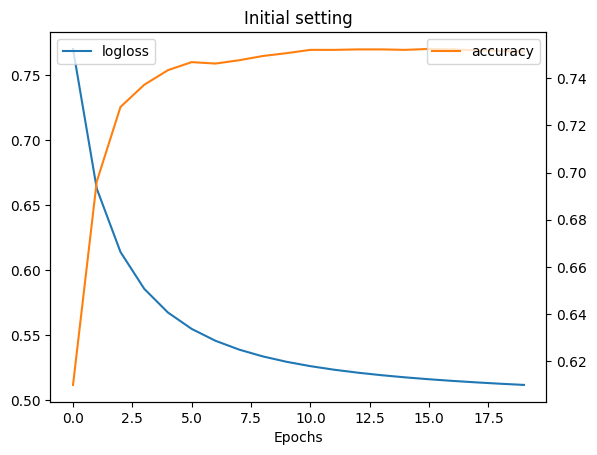

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv("log.txt", sep=",", header=None)

fig, ax = plt.subplots()

ax.plot(data[0], label="logloss")
ax2 = ax.twinx()
ax2.plot([], [])
ax2.plot(data[1], label="accuracy")

ax.set_xlabel("Epochs")
ax.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.title("Initial setting")
plt.show()

In [51]:
%%time
!./classifier_batches.out

initial accuracy: 0.481600
Epoch: 0, LogLoss: 0.709050, Accuracy: 0.596600
Epoch: 1, LogLoss: 0.635738, Accuracy: 0.663400
Epoch: 2, LogLoss: 0.594907, Accuracy: 0.704800
Epoch: 3, LogLoss: 0.569015, Accuracy: 0.718600
Epoch: 4, LogLoss: 0.551019, Accuracy: 0.728400
Epoch: 5, LogLoss: 0.537754, Accuracy: 0.736000
Epoch: 6, LogLoss: 0.527576, Accuracy: 0.738600
Epoch: 7, LogLoss: 0.519526, Accuracy: 0.739600
Epoch: 8, LogLoss: 0.513002, Accuracy: 0.741400
Epoch: 9, LogLoss: 0.507603, Accuracy: 0.743400
Epoch: 10, LogLoss: 0.503054, Accuracy: 0.743600
Epoch: 11, LogLoss: 0.499159, Accuracy: 0.744000
Epoch: 12, LogLoss: 0.495776, Accuracy: 0.744600
Epoch: 13, LogLoss: 0.492799, Accuracy: 0.744400
Epoch: 14, LogLoss: 0.490150, Accuracy: 0.745800
Epoch: 15, LogLoss: 0.487767, Accuracy: 0.745800
Epoch: 16, LogLoss: 0.485604, Accuracy: 0.746000
Epoch: 17, LogLoss: 0.483624, Accuracy: 0.746400
Epoch: 18, LogLoss: 0.481798, Accuracy: 0.747600
Epoch: 19, LogLoss: 0.480102, Accuracy: 0.747800
Dur

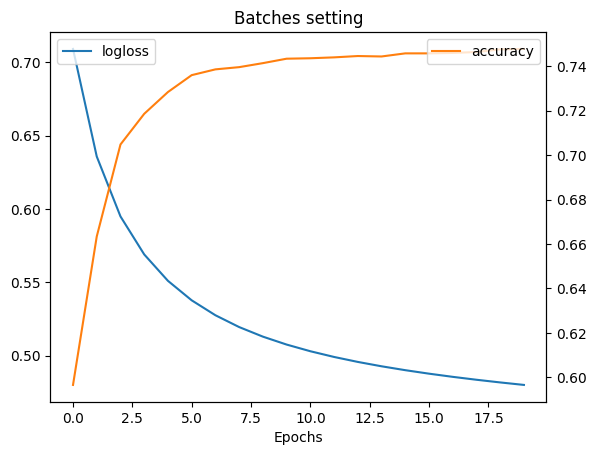

In [52]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv("log_batches.txt", sep=",", header=None)

fig, ax = plt.subplots()

ax.plot(data[0], label="logloss")
ax2 = ax.twinx()
ax2.plot([], [])
ax2.plot(data[1], label="accuracy")

ax.set_xlabel("Epochs")
ax.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.title("Batches setting")
plt.show()

## Hyper-Parameters


**Initial Setting:**

- n_epochs = 20
- learning_rate = 1e-4
- best_accuracy ≈ 0.751
- runtime ≈ 15.2 ms

**Batches Setting:**

- n_epochs = 20
- batch_size = 128
- learning_rate = 1e-4
- best_accuracy ≈ 0.747
- runtime ≈ 177 ms

# Debugging

Compile with debugging info on the host (`-g`) and device (`-G`).


In [53]:
!nvcc -g -G -I cuda-samples/Common/ -L/usr/local/cuda/include -lcublas -lcusolver linear_classification.cu read_csv.cu preprocess_data.cu evaluate_accuracy.cu fmatrix.cu classifier_math.cu cuda_stuff.cu

Run the debugger cuda-gdb, stopping at the first error that is detected. Shows first the call stack on the GPU, the values of local variables, then the call stack on the host (thread 1).


In [54]:
#set cuda memcheck on\n
! printf "set cuda api_failures stop\ncatch throw\nr\nbt\ninfo locals\nthread 1\nbt\n" > tmp.txt
! cat tmp.txt
! cuda-gdb -batch -x tmp.txt ./a.out

set cuda api_failures stop
catch throw
r
bt
info locals
thread 1
bt
Catchpoint 1 (throw)
[Thread debugging using libthread_db enabled]
Using host libthread_db library "/lib/x86_64-linux-gnu/libthread_db.so.1".
[New Thread 0x7ffff5bff000 (LWP 2559)]
[New Thread 0x7fffeffff000 (LWP 2560)]
[Detaching after fork from child process 2561]
[New Thread 0x7fffee7dd000 (LWP 2566)]
Cuda API error detected: cudaLaunchKernel returned (0xde)
#0  0x00007ffff5dad970 in cudbgReportDriverApiError () from /usr/lib64-nvidia/libcuda.so.1
#1  0x00007ffff602b32b in ?? () from /usr/lib64-nvidia/libcuda.so.1
#2  0x00007ffff4954ba7 in ?? () from /usr/lib64-nvidia/libcudadebugger.so.1
#3  0x00007ffff4931b2e in ?? () from /usr/lib64-nvidia/libcudadebugger.so.1
#4  0x00007ffff4942fda in ?? () from /usr/lib64-nvidia/libcudadebugger.so.1
#5  0x00007ffff49280d7 in ?? () from /usr/lib64-nvidia/libcudadebugger.so.1
#6  0x00007ffff4a9e526 in ?? () from /usr/lib64-nvidia/libcudadebugger.so.1
#7  0x00007ffff6042066 in ?? 

In [55]:
!cuda-memcheck ./a.out

/bin/bash: line 1: cuda-memcheck: command not found


# Test


In [56]:
%%writefile test.cu
#include "fmatrix.cuh"
#include "classifier_math.cu"

int main() {
    // create a random matrix
    fmatrix A = fmatrix_create_random_on_device(2,1);
    fmatrix B = fmatrix_create_random_on_device(1,2);
    fmatrix C = fmatrix_create_random_on_device(1,1);
    printf("original matrix:\n");
    fmatrix_device_print(B);
    fmatrix_device_print(C);
    // add the matrix to itself
    fmatrix_tmult(A,1.0,B,C);
    // print
    printf("matrix result:\n");
    fmatrix_device_print(A);
    // free the memory
    fmatrix_free_on_device(&A);
    fmatrix_free_on_device(&B);
    fmatrix_free_on_device(&C);
}

Overwriting test.cu


In [57]:
!nvcc -arch=sm_75 -Wno-deprecated-gpu-targets -g -G -I cuda-samples/Common/ -L/usr/local/cuda/include test.cu fmatrix.cu cuda_stuff.cu

In [58]:
!./a.out

original matrix:
[
0.480439,	-0.123098
]
[
0.480439
]
matrix result:
[
0.230821;
-0.059141
]
